# Drake Analysis: A Deeper Look Into The Discography Of Canada's Rap King

# Introduction

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code"></form>''')

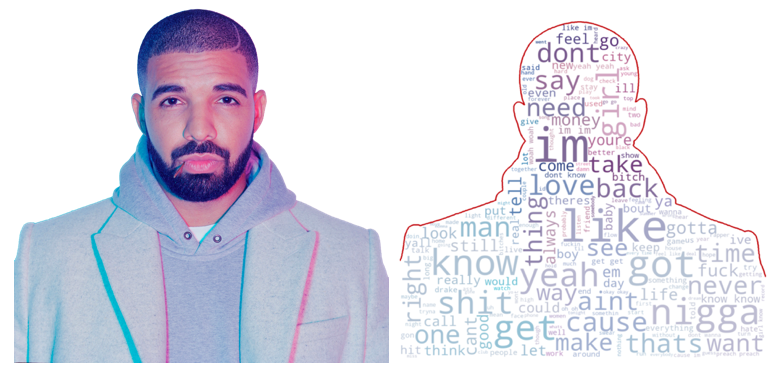

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image('/Users/andreduong/drake-analysis/drake_header.png')

Hip-Hop is my favorite music genre of all time, and Drake is an artist I've listened to for years. Many text mining analyses have been performed on rap lyrics, but I haven't seen enough works that actually dig deeper into one specific artist's discography (or in this case, Drake's discography). In this project, I will apply various Natural Language Process techniques to analyze Drake's lyrics.

As I have been doing a lot of practices on classical Machine Learning, or Deep Learning applied to images (Computer Vision), I don't have nearly as much experience working with text data. This project is my introduction to the world of Natural Language Processing, and text analysis in general.

## What I Have Learned From This Project

In this project, I have practiced:<br>
* Web scraping, data wrangling, visualization, & text mining<br>
* Various NLP techniques: wordcloud, word embedding, tokenization with NLTK, Named Entity Recognition (NER) with SpaCy <br>
* Topic Modeling with Latent Dirichlet Allocation (LDA)<br>
* Interactive Topic Visualization via pyLDAvis

# Building the Dataset

Drake is one of the biggest, if not the biggest, rap artists in the world. Thanks to Drake's popularity, his work is very expansive and well-documented, with five official studio albums and six mixtapes. To obtain the lyrics of all Drake's songs, I scraped the data from [Genius](https://genius.com) using the wonderful [Genius API](https://github.com/johnwmillr/LyricsGenius).

## Data Cleaning

Despite having such easy-to-use API assisting the scraping process, cleaning the data was no easy task. Out of over **500** songs on Genius, there were around **300** tracks that are either duplicates, Live version, diss tracks, or the like, and they were all filtered from the dataset. The lyrics were not clean data either, as there were a lot of noise, redundant characters, and typos. 

To see codes for the whole data preprocessing process, you can check this [notebook](https://github.com/andreduong/drakenerator/blob/master/lyrics-scraping.ipynb). [NBViewer Link](https://nbviewer.jupyter.org/github/andreduong/drakenerator/blob/master/data-preprocessing.ipynb).

# Career Overview

In [3]:
# import necessary tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# set a figure size/color scheme for all the plots we shall be drawing in this notebook
sns.set(rc={'figure.figsize': (12, 10)}, style='darkgrid', palette='Reds')

First, let's load data from the csv file:

In [5]:
# load the data
data = pd.read_csv('lyrics.csv')
data.head(10)

,name,album,year,lyrics
0,Right to Left,Born Successful,2009,blue green jewels with the supreme fuel and l...
1,Forever (Born Successful),Born Successful,2009,it may not mean nothing to yall but understan...
2,The Winner,Born Successful,2009,i m performing tonight you know that shit gon...
3,I Do This,Born Successful,2009,uh shits all good the deal got signed and my ...
4,Fallen,Born Successful,2009,yeah its drake kc we was just walking just sm...
5,Do It Now,Born Successful,2009,uh yeah alright uh well alright yeah well alr...
6,The Search,Born Successful,2009,they say we killin em all all all all hip hop...
7,Juice,Born Successful,2009,boi 1da drizzy yall dont really like me i can...
8,Man of the Year,Comeback Season,2007,damn i done walked in here looking like the m...
9,Give Ya,Comeback Season,2007,check look and i aint tryna get to know nobod...


In [6]:
data.tail(10)

,name,album,year,lyrics
204,Pop Style,Views,2016,this sound like some forty three oh one shit ...
205,Grammys,Views,2016,yeah yeah yeah yeah jheeze yeah right look lo...
206,Redemption,Views,2016,yeah i get it i get it yeah why would i say a...
207,Too Good,Views,2016,oh yeah yeah yeah oh yeah yeah yeah yeah look...
208,Controlla,Views,2016,right my yiy just changed you just buzzed the...
209,Views [Trailer],Views,2016,the 6 raptors diamond key new ride old ride ba...
210,Summers Over Interlude,Views,2016,ooh baby yeah days in the sun and nights in t...
211,Views,Views,2016,question is will i ever leave you the answer ...
212,With You,Views,2016,its about us right now girl where you going i...
213,One Dance,Views,2016,baby i like your style grips on your waist fr...


## From "Comeback Season" to "The Best In The World Pack"

Drake has a relatively huge, rich discography. According to this dataset, for 13 years of his music career, Drake has had 18 albums/mixtapes in total.

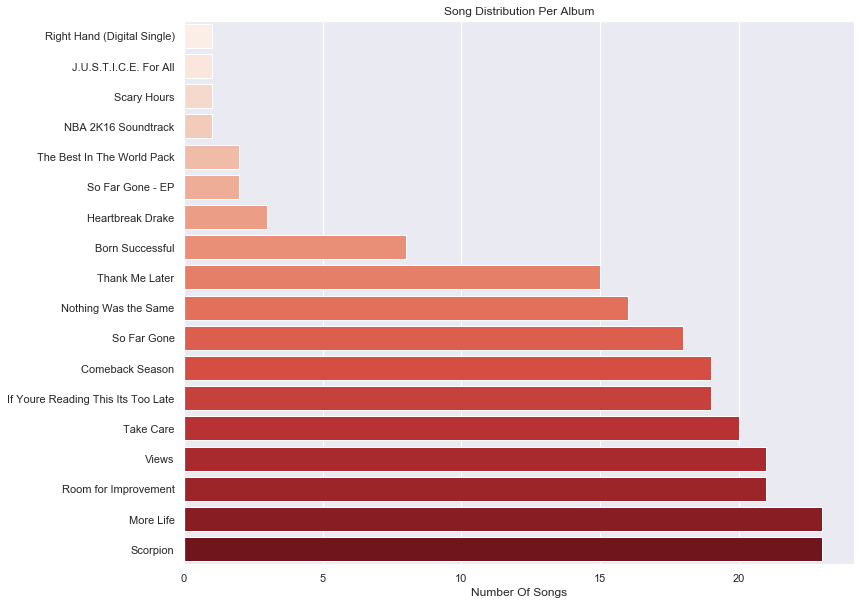

In [7]:
sns.countplot(y=data['album'].values, order=data['album'].value_counts(ascending=True).index, palette='Reds')
plt.title('Song Distribution Per Album')
plt.xlabel('Number Of Songs', fontsize=12)
plt.show()

## Drake In The Streaming Era: Quantity > All?

In this streaming eras, artists tend to put as many tracks as possible in one album to boost their streaming numbers. This is true for Drake as well: his more recent albums (More Life, Scorpion, Views) all have higher numbers of songs comparing to his older ones with the exception of 2009, when he released three tapes in one year.

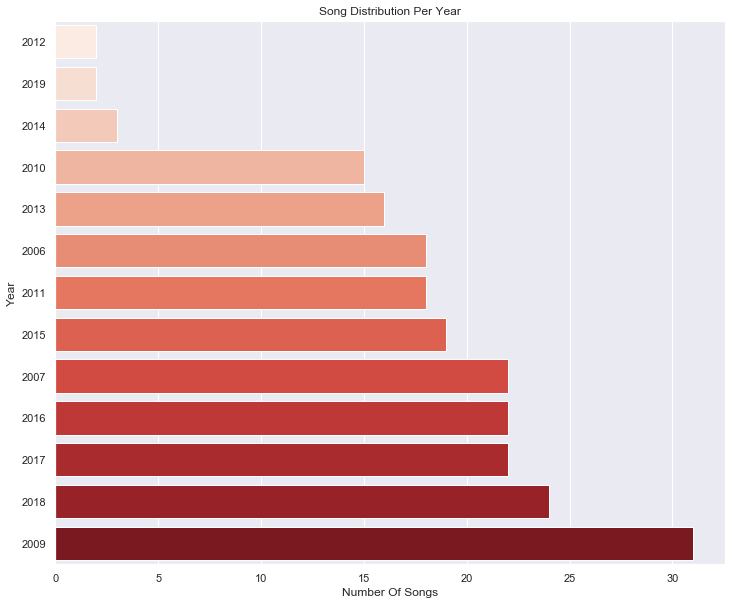

In [8]:
sns.countplot(y=data['year'].values, order=data['year'].value_counts(ascending=True).index, palette='Reds')
plt.title('Song Distribution Per Year')
plt.ylabel('Year', fontsize=12)
plt.xlabel('Number Of Songs', fontsize=12)
plt.show()

## WordCloud

In [9]:
# create a stopwords list
stopwords = nltk.corpus.stopwords.words('english') #are lowercase
nltkStopwordsWithAdditions = stopwords + \
                             ['la', #comes up a lot (like 'la-la-la') but isn't a word so don't include it
                              'eh', 'ayy', #same as 'la'. 'eh' as in pronounced like 'aye'
                              'oh', 'ooh', #an exclamation with no real meaning but ranks highly so exclude
                              'us', 'u', 'ya', #different forms of 'you' which is a stopword
                              'na', 'ta', #alt forms of 'to' which is a stopword. From 'gonna', 'wanna', 'gotta'
                              'nah', #usage a mix of a sung-only word and slang for 'no' which is a stopword
                              'po', 'woo', 'doo', 'ah', 'uh', 'uhh' #sung-only words
                             ]

In [10]:
drake = np.array(Image.open("./drake.png"))
transformed_drake_mask = drake

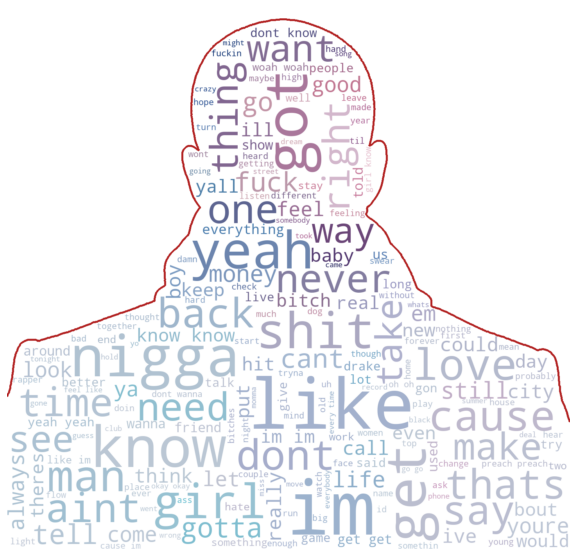

In [11]:
wordcloud_general = WordCloud(stopwords=stopwords, background_color='white',
                              contour_width=5, contour_color='firebrick',
                              mask=transformed_drake_mask).generate(' '.join(data['lyrics']))
image_colors = ImageColorGenerator(transformed_drake_mask)
plt.imshow(wordcloud_general.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.png', format='png')
plt.show()

# Lyrics Analysis

# Words Per Song

In [12]:
# create a list for number of words per song
number_of_words_per_song_list=[]

# add elements to the list using a for loop
for i in range(213):
    number_of_words_per_song_list.append(len(data['lyrics'][i].split(' ')))

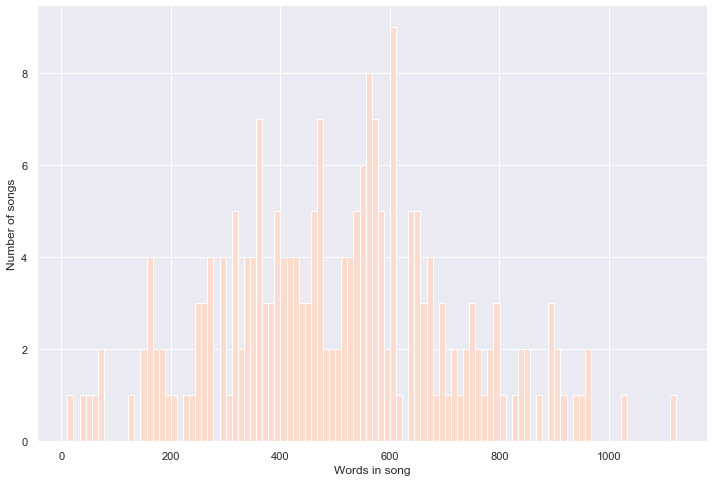

In [13]:
# plot the graph
fig, axs = plt.subplots(figsize=(12, 8))
axs.hist(number_of_words_per_song_list, 100)
axs.set_xlabel("Words in song")
axs.set_ylabel("Number of songs")
# hide the right and top spines
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
plt.show()

# Tokenizing With NLTK

Tokenization is a 

In [14]:
tokenizer = RegexpTokenizer(r'\w+')

data['tokens'] = data['lyrics'].apply(tokenizer.tokenize)
data.head(10)

,name,album,year,lyrics,tokens
0,Right to Left,Born Successful,2009,blue green jewels with the supreme fuel and l...,"[blue, green, jewels, with, the, supreme, fuel..."
1,Forever (Born Successful),Born Successful,2009,it may not mean nothing to yall but understan...,"[it, may, not, mean, nothing, to, yall, but, u..."
2,The Winner,Born Successful,2009,i m performing tonight you know that shit gon...,"[i, m, performing, tonight, you, know, that, s..."
3,I Do This,Born Successful,2009,uh shits all good the deal got signed and my ...,"[uh, shits, all, good, the, deal, got, signed,..."
4,Fallen,Born Successful,2009,yeah its drake kc we was just walking just sm...,"[yeah, its, drake, kc, we, was, just, walking,..."
5,Do It Now,Born Successful,2009,uh yeah alright uh well alright yeah well alr...,"[uh, yeah, alright, uh, well, alright, yeah, w..."
6,The Search,Born Successful,2009,they say we killin em all all all all hip hop...,"[they, say, we, killin, em, all, all, all, all..."
7,Juice,Born Successful,2009,boi 1da drizzy yall dont really like me i can...,"[boi, 1da, drizzy, yall, dont, really, like, m..."
8,Man of the Year,Comeback Season,2007,damn i done walked in here looking like the m...,"[damn, i, done, walked, in, here, looking, lik..."
9,Give Ya,Comeback Season,2007,check look and i aint tryna get to know nobod...,"[check, look, and, i, aint, tryna, get, to, kn..."


In [15]:
all_words = [word for tokens in data['tokens'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data['tokens']]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

108095 words total, with a vocabulary size of 7480
Max sentence length is 1122


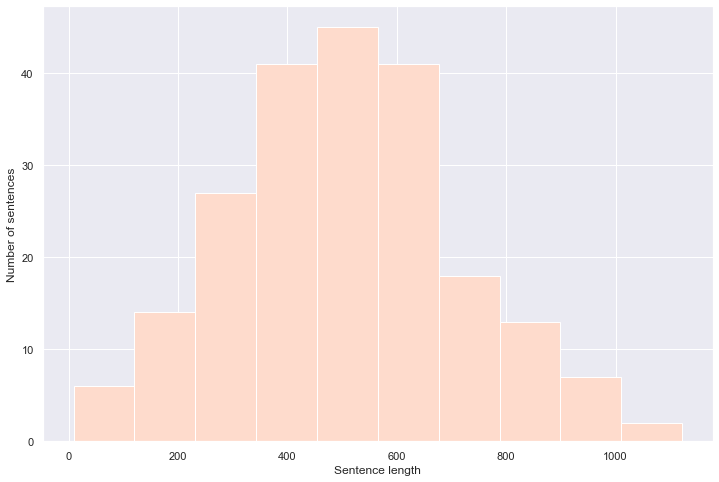

In [16]:
fig = plt.figure(figsize=(12, 8)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

# Adding Word Counts & Unique Word Counts

In [17]:
word_counts = []
unique_word_counts = []
for i in range (0, len(data)):
    word_counts.append(len(data.iloc[i]['lyrics'].split()))
    unique_word_counts.append(len(set(data.iloc[i]['lyrics'].split())))
data['Word Counts'] = word_counts
data['Unique Word Counts'] = unique_word_counts

In [18]:
data = data.sort_values('year')
data.head(10)

,name,album,year,lyrics,tokens,Word Counts,Unique Word Counts
106,Make Things Right,Room for Improvement,2006,look if you a girl with the aspirations of be...,"[look, if, you, a, girl, with, the, aspiration...",456,223
109,Intro (Room For Improvement),Room for Improvement,2006,yo whats going on this is drake and ima let y...,"[yo, whats, going, on, this, is, drake, and, i...",184,92
108,Try Harder,Room for Improvement,2006,sometimes i feel like lohan and hilary duff a...,"[sometimes, i, feel, like, lohan, and, hilary,...",395,198
107,Thrill Is Gone,Room for Improvement,2006,loves lost loves gone love lost love is gone l...,"[loves, lost, loves, gone, love, lost, love, i...",579,260
105,Video Girl,Room for Improvement,2006,uh yea get in my slick rick mode na mean im a...,"[uh, yea, get, in, my, slick, rick, mode, na, ...",782,338
104,All This Love,Room for Improvement,2006,southern smoke this another one from your boy ...,"[southern, smoke, this, another, one, from, yo...",458,172
103,Pianist Hands,Room for Improvement,2006,thank you ms graham for coming today you look ...,"[thank, you, ms, graham, for, coming, today, y...",161,101
110,Drakes Voice Mail Box #2,Room for Improvement,2006,what up this kim damn i ve been trying to get...,"[what, up, this, kim, damn, i, ve, been, tryin...",43,28
102,Drakes Voice Mail Box #1,Room for Improvement,2006,the man drake puts it the fuck down he s doin...,"[the, man, drake, puts, it, the, fuck, down, h...",162,85
100,Do What You Do,Room for Improvement,2006,stance on lean leg up on the wall my niggas c...,"[stance, on, lean, leg, up, on, the, wall, my,...",829,262


# Is Drake Becoming Less Lyrical? Actually, No.

In [19]:
summary_dataset = pd.DataFrame()
years = data['year'].unique().tolist()
for i in range(0, len(years)):
    row = {
        "year": years[i],
        "Average Words": data['Word Counts'][data['year'] == years[i]].mean(),
        "Unique Words": data['Unique Word Counts'][data['year'] == years[i]].mean()
    }
    summary_dataset = summary_dataset.append(row, ignore_index=True)
summary_dataset['year'] = summary_dataset['year'].astype(int)

In [20]:
characteristics = data.groupby('year').count()

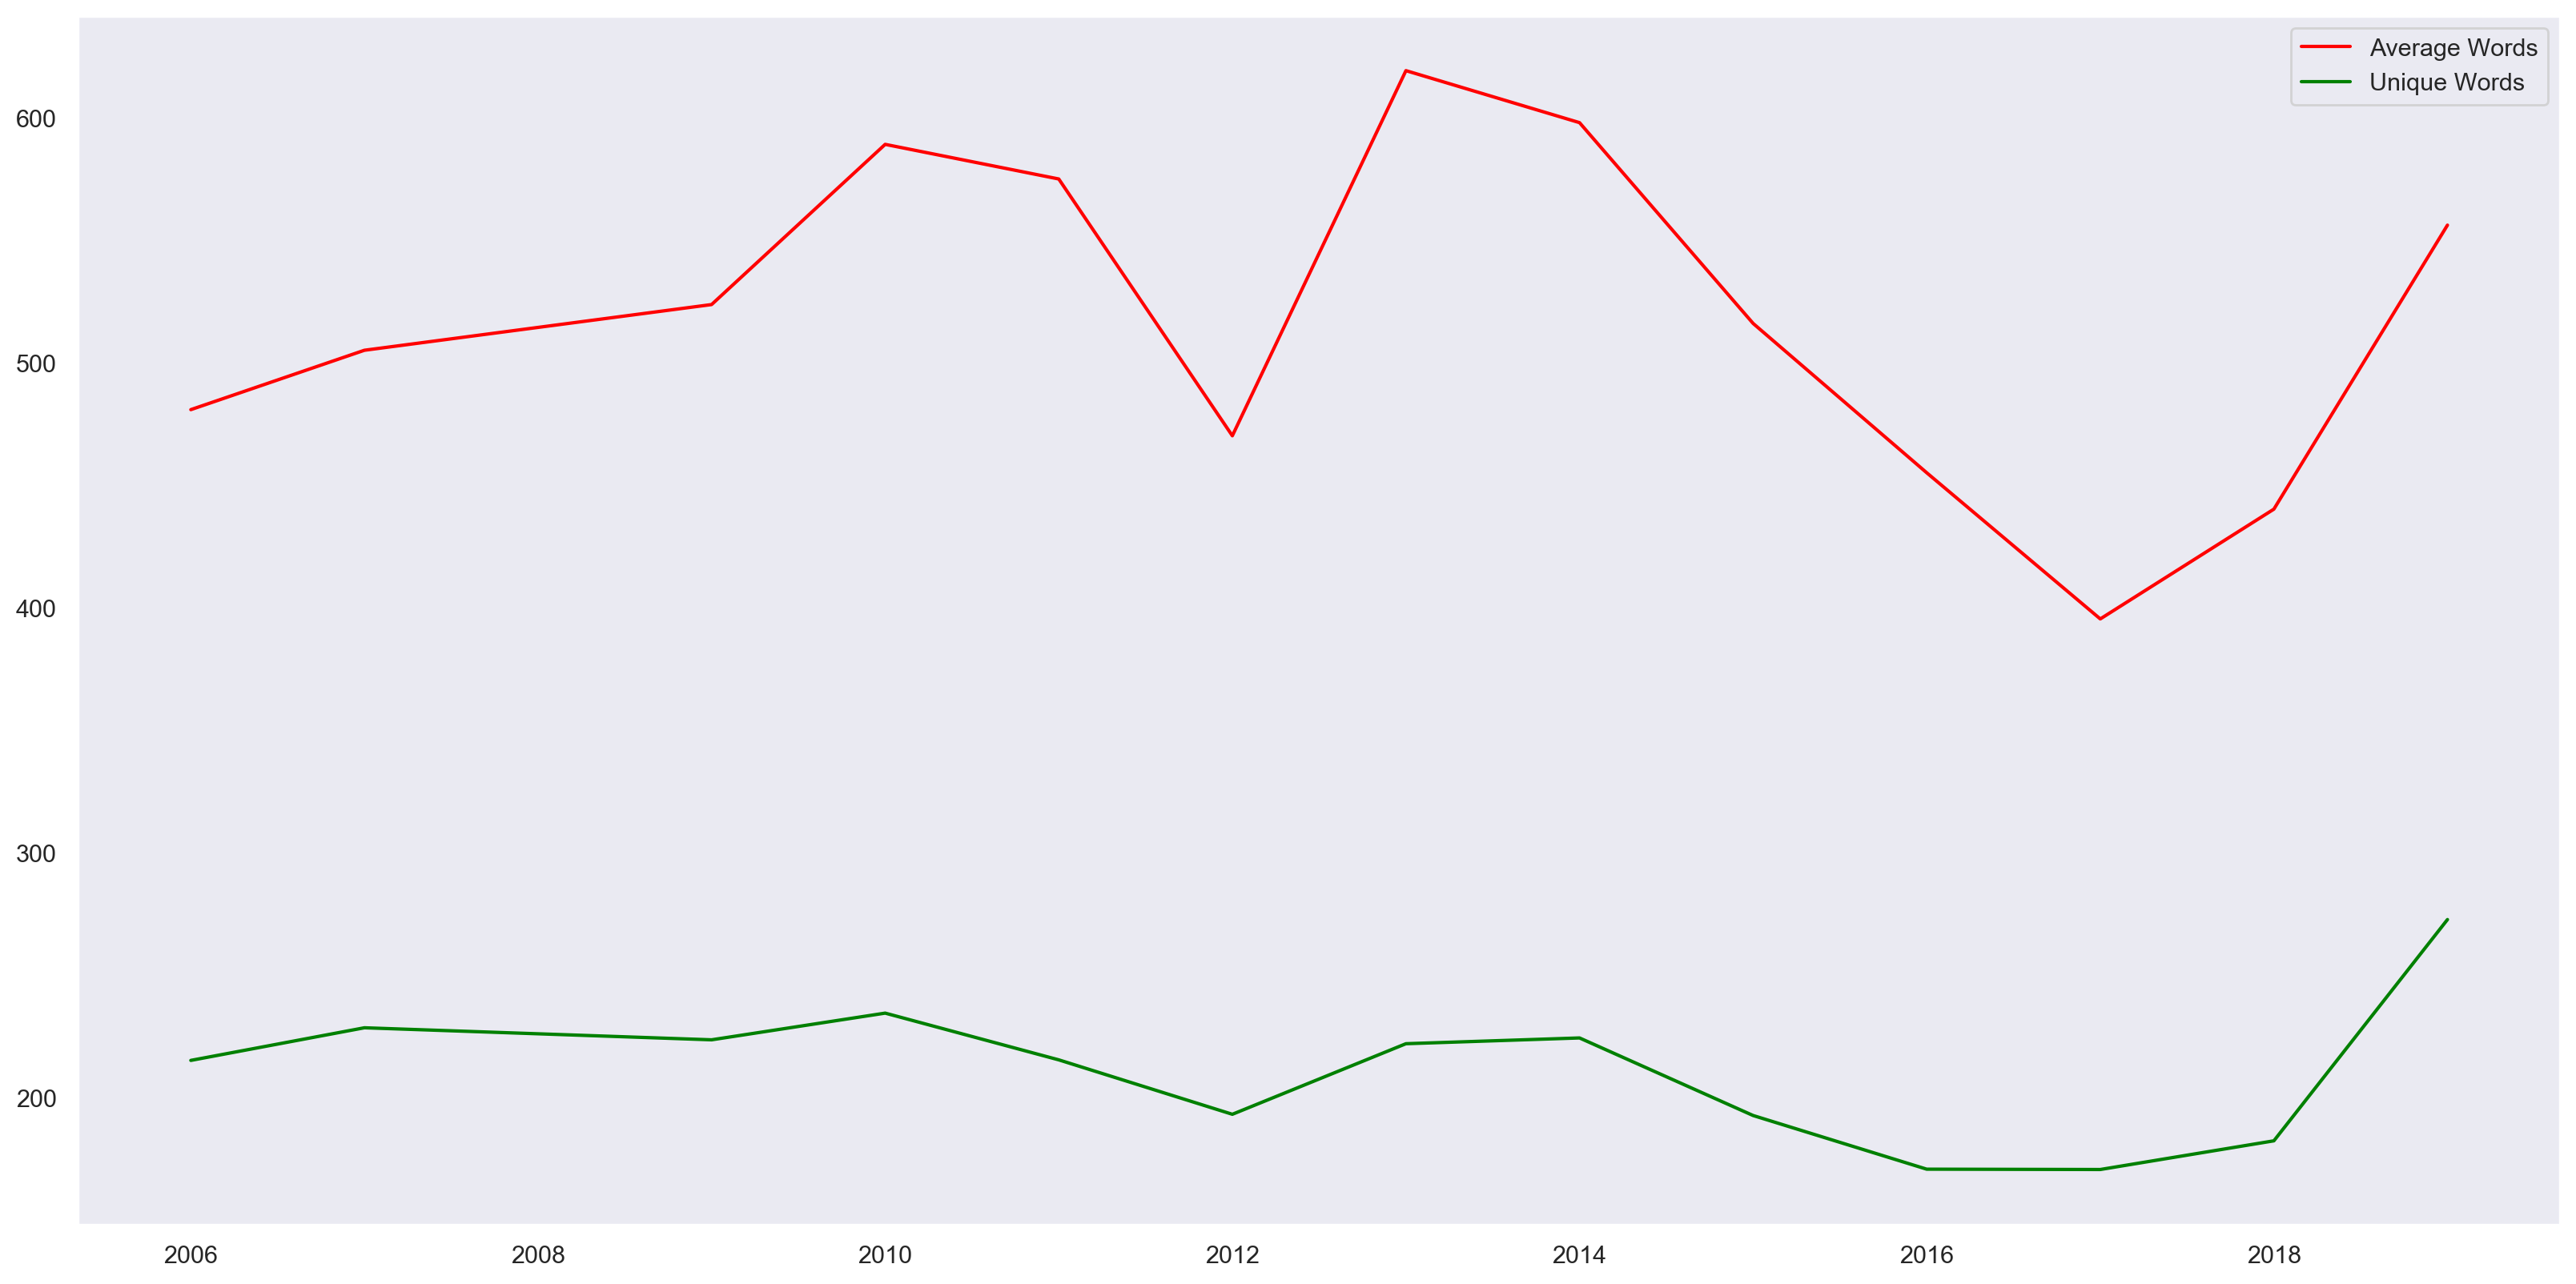

In [21]:
plt.figure(figsize=(20,10), dpi=200)
plt.plot(summary_dataset['year'], summary_dataset['Average Words'].values, color="red", label="Average Words")
plt.plot(summary_dataset['year'], summary_dataset['Unique Words'].values, color="green", label = "Unique Words")
plt.grid()
plt.legend()
plt.show()

From the graph above, we can see:<br>
<br>
* "Take Care", Drake's 2011-2012 album that is widely recognized as his best albums, is actually one of his less lyrical ones.<br>
<br>
* Lyrics wise, Drake was at his worst in 2016-2017, when he made a breakthrough commercially with the mega hit "Hotline Bling" that helped him top the charts from all around the world and become the biggest artist across all genres at that time. It's a dilemma for most Hip-Hop artists: you make catchy, commercial friendly songs that will top the charts and make you a lot of money/fame, in exchange for your artistry.<br>
<br>
* However, Drake is making a comeback. Since 2018, both of his lyrical statistics has been skyrocketing, and they're going as strong as ever. As of now, Drake is currently at his peak lyrically and he shows no signs of stopping.

# Named Entity Recognition With SpaCy

Named entity recognition (NER) is probably the first step towards information extraction that seeks to locate and classify named entities in text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc.

In this specific case, NER can help us have a deeper look into the substances in Drake's music over time. This includes ..... In this section, I will build a Named Entity Recognizer using SpaCy.

In [22]:
# import necessary tools
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [23]:
data_lyrics = data['lyrics']
lyrics_token = ''
for i in data['lyrics']:
    lyrics_token += str(i)

In [24]:
doc = nlp(lyrics_token)
print([(X.text, X.label_) for X in doc.ents])

[('the weekend', 'DATE'), ('every week', 'DATE'), ('five', 'CARDINAL'), ('four', 'CARDINAL'), ('two', 'CARDINAL'), ('the weekend', 'DATE'), ('s', 'PERSON'), ('one', 'CARDINAL'), ('one', 'CARDINAL'), ('first', 'ORDINAL'), ('winter', 'DATE'), ('19', 'CARDINAL'), ('second', 'ORDINAL'), ('first', 'ORDINAL'), ('first', 'ORDINAL'), ('a couple a years', 'DATE'), ('days', 'DATE'), ('2', 'CARDINAL'), ('ten', 'CARDINAL'), ('ten', 'QUANTITY'), ('half', 'CARDINAL'), ('first', 'ORDINAL'), ('first', 'ORDINAL'), ('last year', 'DATE'), ('every day', 'DATE'), ('today', 'DATE'), ('today', 'DATE'), ('one', 'CARDINAL'), ('all week', 'DATE'), (' ', 'NORP'), ('06', 'CARDINAL'), ('this year', 'DATE'), ('the spring', 'DATE'), ('the fall', 'DATE'), ('tonight', 'TIME'), ('all day', 'DATE'), ('1da', 'ORDINAL'), ('winter', 'DATE'), ('1da', 'ORDINAL'), ('the spring', 'DATE'), ('the fall', 'DATE'), ('the spring', 'DATE'), ('the fall', 'DATE'), ('sixteen', 'CARDINAL'), ('the spring', 'DATE'), ('the fall', 'DATE'), (

In [25]:
print('There are ' + str(len(doc.ents)) + ' entities in total. They are represented as 14 unique labels:')

There are 1277 entities in total. They are represented as 14 unique labels:


In [26]:
labels = [x.label_ for x in doc.ents]
Counter(labels)

Counter({'DATE': 332,
         'CARDINAL': 571,
         'PERSON': 9,
         'ORDINAL': 95,
         'QUANTITY': 27,
         'NORP': 34,
         'TIME': 185,
         'GPE': 4,
         'MONEY': 11,
         'ORG': 4,
         'LOC': 1,
         'PERCENT': 1,
         'FAC': 2,
         'PRODUCT': 1})

In [27]:
items = [x.text for x in doc.ents]
print('The following are three most frequent tokens: ' + str(Counter(items).most_common(3)))

The following are three most frequent tokens: [('one', 150), ('first', 56), ('two', 54)]


Let’s randomly select one sentence to learn more:

In [28]:
sentences = [x for x in doc.sents]
print(sentences[20])

my mans from down south ya understand the number one dj in the south to be exact


We run displacy.render to generate the raw markup:

In [29]:
displacy.render(nlp(str(sentences[20])), jupyter=True, style='ent')

Using spaCy’s built-in displaCy visualizer, here’s what the above sentence and its dependencies look like:

In [30]:
displacy.render(nlp(str(sentences[20])), style='dep', jupyter = True, options = {'distance': 120})

Next, we verbatim, extract part-of-speech and lemmatize this sentence:

In [31]:
[(x.orth_,x.pos_, x.lemma_) for x in [y 
                                      for y
                                      in nlp(str(sentences[20])) 
                                      if not y.is_stop and y.pos_ != 'PUNCT']]

[('mans', 'NOUN', 'man'),
 ('south', 'ADV', 'south'),
 ('ya', 'PRON', 'ya'),
 ('understand', 'VERB', 'understand'),
 ('number', 'NOUN', 'number'),
 ('dj', 'NOUN', 'dj'),
 ('south', 'NOUN', 'south'),
 ('exact', 'ADJ', 'exact')]

In [32]:
print([(x, x.ent_iob_, x.ent_type_) for x in sentences[20]])

[(my, 'O', ''), (mans, 'O', ''), (from, 'O', ''), (down, 'O', ''), (south, 'O', ''), (ya, 'O', ''), (understand, 'O', ''), (the, 'O', ''), (number, 'O', ''), (one, 'B', 'CARDINAL'), (dj, 'O', ''), (in, 'O', ''), (the, 'O', ''), (south, 'O', ''), (to, 'O', ''), (be, 'O', ''), (exact, 'O', '')]


Finally, we visualize the entity of the entire lyrics dataset:

In [33]:
displacy.render(doc, jupyter=True, style='ent')

# Topic Modeling via pyLDAvis

Here we go, the Machine Learning part of the project.

[Topic modeling](https://en.wikipedia.org/wiki/Topic_model?source=post_page---------------------------) is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. [Latent Dirichlet Allocation](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/?source=post_page---------------------------) (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

## Intent

In this section, first I put all song lyrics into a list. Then, using Scikit-Learn's CountVectorizer, I will create a bag-of-words corpus representing all the lyrics. Lastly, I will train an LDA model, fit it, and implement an interactive, web-based topic visualization via [pyLDAvis](https://github.com/bmabey/pyLDAvis).

In [34]:
# import necessary tools
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn

## Bag-of-word model

In [35]:
# create a bag-of-word model for the lyrics list
stopwords = nltk.corpus.stopwords.words('english')
words=['thats', 'yeah', 'got', 'get', 'im', 'its', 'dont']
for x in words:
    stopwords.append(x)
    
tf_vectorizer = CountVectorizer(stop_words=stopwords)
tf = tf_vectorizer.fit_transform(all_words)
tf_words = tf_vectorizer.get_feature_names()

## LDA model

In [36]:
# create an LDA model
ldamodel = LatentDirichletAllocation(n_topics=5, max_iter=100, learning_method='online', 
                                     learning_offset=50., random_state=0)

In [37]:
# fit the model
ldamodel.fit(tf)

/Users/andreduong/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=5, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

## Interactive Topic Visualization via pyLDAvis

In [38]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(ldamodel, tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      57.442478 -58.812904       1        1  20.084882
1      79.604652  36.124538       2        1  20.015259
3      28.370337  11.887290       3        1  19.980483
2      98.064362 -19.526230       4        1  19.964050
4       2.437119 -38.510838       5        1  19.955326, topic_info=     Category        Freq     Term       Total  loglift  logprob
3689  Default  902.000000     like  902.000000  30.0000  30.0000
3531  Default  823.000000     know  823.000000  29.0000  29.0000
5676  Default  396.000000     shit  396.000000  28.0000  28.0000
2723  Default  356.000000       go  356.000000  27.0000  27.0000
2684  Default  354.000000     girl  354.000000  26.0000  26.0000
1084  Default  302.000000    cause  302.000000  25.0000  25.0000
4292  Default  299.000000    never  299.000000  24.0000  24.0000
194   Default  298.000000     aint  298.000000  23.0000  23.0000
466   Default  293.000000     back  293.000000  22.0000  22.0000
3793  Default  287.000000     love  287.000000  21.0000  21.0000
3879  Default  276.000000      man  276.000000  20.0000  20.0000
6567  Default  275.000000     time  275.000000  19.0000  19.0000
4428  Default  273.000000      one  273.000000  18.0000  18.0000
5313  Default  268.000000    right  268.000000  17.0000  17.0000
4316  Default  265.000000   niggas  265.000000  16.0000  16.0000
4315  Default  261.000000    nigga  261.000000  15.0000  15.0000
4266  Default  259.000000     need  259.000000  14.0000  14.0000
5487  Default  258.000000      say  258.000000  13.0000  13.0000
4409  Default  249.000000       oh  249.000000  12.0000  12.0000
6431  Default  237.000000     tell  237.000000  11.0000  11.0000
1022  Default  233.000000     cant  233.000000  10.0000  10.0000
3863  Default  223.000000     make  223.000000   9.0000   9.0000
6358  Default  222.000000     take  222.000000   8.0000   8.0000
5567  Default  213.000000      see  213.000000   7.0000   7.0000
7038  Default  208.000000      way  208.000000   6.0000   6.0000
6998  Default  202.000000    wanna  202.000000   5.0000   5.0000
2757  Default  193.000000    gotta  193.000000   4.0000   4.0000
7001  Default  191.000000     want  191.000000   3.0000   3.0000
2599  Default  178.000000     fuck  178.000000   2.0000   2.0000
6127  Default  179.000000    still  179.000000   1.0000   1.0000
...       ...         ...      ...         ...      ...      ...
3689   Topic5  901.861025     like  902.562495   1.6109  -2.4379
2723   Topic5  355.674589       go  356.376062   1.6097  -3.3683
5313   Topic5  267.699218    right  268.400691   1.6091  -3.6525
4315   Topic5  260.373531    nigga  261.075001   1.6090  -3.6802
5567   Topic5  212.453187      see  213.154658   1.6084  -3.8836
2106   Topic5  157.132456       em  157.833925   1.6072  -4.1852
2742   Topic5  148.693864     good  149.395339   1.6070  -4.2404
3326   Topic5  128.415335      ive  129.116807   1.6062  -4.3871
5027   Topic5  101.543299      put  102.244772   1.6048  -4.6218
991    Topic5   98.757159     call   99.458631   1.6046  -4.6497
2739   Topic5   96.311383      gon   97.012857   1.6044  -4.6747
2931   Topic5   94.872321     hard   95.573794   1.6043  -4.6898
3461   Topic5   89.852784     keep   90.554255   1.6039  -4.7442
7170   Topic5   82.775812     woah   83.477284   1.6032  -4.8262
2399   Topic5   80.949823     find   81.651299   1.6030  -4.8485
7071   Topic5   78.506327     well   79.207801   1.6028  -4.8792
6605   Topic5   72.064341     told   72.765813   1.6020  -4.9648
5418   Topic5   68.957763      run   69.659233   1.6016  -5.0088
483    Topic5   64.620659      bad   65.322134   1.6009  -5.0738
6737   Topic5   61.752299      try   62.453769   1.6004  -5.1192
3585   Topic5   58.034390     late   58.735864   1.5997  -5.1813
3065   Topic5   57.160653     hold   57.862125   1.5995  -5.1965
1808   Topic5   55.592492      die   56.293968   1.5991